In [1]:
%%html
<style>
    @page {
        size: A3 landscape;
        margin: 0;
    }
    .jp-Cell:first-child {
        display: none;
    }
    .jp-RenderedMermaid {
        justify-content: center;
    }
    h2 {
        page-break-before: always;
    }
</style>

# View Synthesis

> Implement by NeRF in pyTorch

## Task Description

"View synthesis" is a task which
generating images of a 3D scene from a specific point of view.

## Solution Description

"NeRF" (Neural Radiance Field) solved "View synthesis"
by representing 3D scene using a neural network.

## Pipeline Description

1. Preprocessing
2. Inference
3. Rendering
4. Training

## Pipeline Description - Preprocessing

{{ True image }} → {{ Position, Direction, True color }}

## Pipeline Description - Inference

{{ Position, Direction }} → {{ Volumetric sampling }} → {{ Positional encoding }} → {{ Network }} → {{ Color, Density }}

## Pipeline Description - Rendering

{{ Color, Density }} → {{ Alpha blending }} → {{ Rendered color }}

## Pipeline Description - Training

{{ True color, Rendered color, Network }} → {{ Network }}

```mermaid
graph TD
    subgraph Preprocessing
        ti[True Image]
        cp[Camera Posture]
        tc[True Color]
    end

    subgraph Inference
        vs[Volume Sampling]
        B --> C[Ray Generation]
        C --> D[Ray Batching]
        D --> E[Volume Sampling]
        E --> F[Positional Encoding]
        F --> G[Network]
        G --> H[Color, Density]
    end

    subgraph Rendering
        H --> I[Alpha Blending]
        I --> J[Rendered Color]
    end

    subgraph Training
        B -.-> L[Loss Calculation]
        J -.-> L
        G -.-> L
        L --> G
    end
```

## Optimization Description

1. Positional Encoding of input coordinates
    - For learning high-frequency features
    - Using Fourier features
2. Stochastic Gradient Descent
    - For minimizing the error between the true and rendered images
    - Choosing a random image from the dataset each iteration
<!-- 3. Hierarchical Sampling
    - For high-frequency representions
    - Using two networks with different sample size -->

## Inference Details

### Positional Encoding

The raw and encoded coordinate values will be concatenated to form the network input.

Each coordinate value in `Position` and `Direction` is encoded as follows:

$$
Encode_{N}(p) \\

= \{\sin (2^0 \pi p), \cos (2^0 \pi p), \ldots, \sin (2^{N-1} \pi p), \cos (2^{N-1} \pi p)\} \\

= \{\sin (2^0 \pi p), \sin (\frac{\pi}{2} + 2^0 \pi p), \ldots, \sin (2^{N-1} \pi p), \sin (\frac{\pi}{2} + 2^{N-1} \pi p)\} \\

\text{where } p \in \mathbb{R}, \ N \in \mathbb{N}, \ Encode_{N}(p) \in \mathbb{R}^{2N}
$$

The encoded dimensions are calculated as follows:

| Input     | Dimension | N   | Encoded Dimension |
| --------- | --------- | --- | ----------------- |
| Position  | 3         | 10  | $3 (1 + 2N) = 63$ |
| Direction | 3         | 4   | $3 (1 + 2N) = 27$ |


## Inference Details (Cont.)

### Neural Prediction

The neural network is a multi-layer perceptron (MLP) with the following structure:
- The density is not dependent on the direction
- The fifth hidden layer concatenates the input as a skip connection

```mermaid
%%{init: {
    "theme": "neutral",
    "themeVariables": {
        "fontFamily": "Menlo, monospace",
        "fontSize": "10px"
    }
}}%%
flowchart TD
    ip1([Input Position 3])
    ep1([Encoded Position 63])
    h1([Hidden Layer 256])
    h2([Hidden Layer 256])
    h3([Hidden Layer 256])
    h4([Hidden Layer 256])
    h5([Hidden Layer 256])
    ip2([Input Position 3])
    ep2([Encoded Position 63])
    h6([Hidden Layer 256])
    h7([Hidden Layer 256])
    h8([Hidden Layer 256])
    od([Output Density 1])
    iof([Input/Output Feature 256])
    id([Input Direction 3])
    ed([Encoded Direction 27])
    ha([Additional Hidden Layer 128])
    oc([Output Color 3])

    ip1 -->|Encode| ep1
    ep1 -->|ReLU| h1
    h1 -->|ReLU| h2
    h2 -->|ReLU| h3
    h3 -->|ReLU| h4
    h4 -->|ReLU| h5
    ip2 -->|Encode| ep2
    ep2 ---|Concatenate| h5
    h5 -->|ReLU| h6
    h6 -->|ReLU| h7
    h7 -->|ReLU| h8
    h8 -->|ReLU| od
    h8 --> iof
    id -->|Encode| ed
    ed ---|Concatenate| iof
    iof -->|ReLU| ha
    ha -->|Sigmoid| oc

    style ip1 fill:palegreen
    style ip2 fill:palegreen
    style id fill:palegreen
    style ep2 fill:mediumaquamarine
    style ep1 fill:mediumaquamarine
    style ed fill:mediumaquamarine
    style h1 fill:deepskyblue
    style h2 fill:deepskyblue
    style h3 fill:deepskyblue
    style h4 fill:deepskyblue
    style h5 fill:deepskyblue
    style h6 fill:deepskyblue
    style h7 fill:deepskyblue
    style h8 fill:deepskyblue
    style ha fill:deepskyblue
    style iof fill:tan
    style od fill:salmon
    style oc fill:salmon
```

## Inference Details (Cont.)

### Stratified Point Sampling

To represent a continuous scene, we can sample points along the rays, which can be written as $r(t_{i}) = o + d t_{i}$ where:
- $o$ is the origin point
- $d$ is the direction vector
- $t_{i} \sim U[\frac{i - 1}{N}, \frac{i}{N}]$ is the distance along the ray (Stratified sampling)
- $N$ is the number of samples per ray, we use $N = 32$

## Rendering Details (Cont.)

### Volume Rendering

$$
\hat{C} = \sum_{i=1}^{N} T_{i} \alpha_{i} c_{i} \\
$$

## Training Details

| Module Name                       | Details                                    |
| --------------------------------- | ------------------------------------------ |
| Weight updater - Adam             | Learning rate is $5 \times 10^{-4}$        |
| Loss function - Mean Square Error | Error between the true and rendered colors |
| Data loader                       | 1024 rays per batch to reduce memory cost  |

$$
Loss = \frac{\Sigma_{r \in \mathbb{R}} (C_{rendered}(r) - C_{true}(r))^2}{|\mathbb{R}|} \\

\text{where } \mathbb{R} \text{ is a batch of rays}
$$


## References

1. View synthesis. (n.d.). In Wikipedia. Retrieved from https://en.wikipedia.org/wiki/View_synthesis
2. Neural radiance field. (n.d.). In Wikipedia. Retrieved from https://en.wikipedia.org/wiki/Neural_radiance_field
3. Mildenhall, B., Srinivasan, P. P., Tancik, M., Barron, J. T., Ramamoorthi, R., & Ng, R. (2020). NeRF: Neural radiance fields for image synthesis. arXiv preprint arXiv:2003.08934. Retrieved from https://arxiv.org/pdf/2003.08934
4. Tancik, M., Srinivasan, P. P., Mildenhall, B., Fridovich-Keil, S., Raghavan, N., Singhal, U., Ramamoorthi, R., Barron, J. T., & Ng, R. (2020). Fourier features let networks learn high frequency functions in low dimensional domains. NeurIPS. Retrieved from https://arxiv.org/pdf/2006.10739

## Implementation

----
#### Positional Encoding

In [2]:
from torch import Tensor
from torch.nn import Module
from torch.types import Device


class PositionalEncoder(Module):
    """
    ## Arguments
    - `encoding_factor`: `int`

    ## Inputs
    1. `Vectors`: `[..., dim]`

    ## Outputs
    1. `Features`: `[..., dim * (2 * encoding_factor + 1)]`
    """

    def __init__(self, encoding_factor: int, device: Device | None = None):
        import torch

        super(PositionalEncoder, self).__init__()

        encoding_factor = max(int(encoding_factor), 0)

        freq_lvls = torch.arange(encoding_factor, device=device)
        self.freq = ((2 ** freq_lvls) * torch.pi).repeat_interleave(2)
        sine_offsets = torch.tensor([0.0, torch.pi / 2], device=device)
        self.offsets = sine_offsets.repeat(encoding_factor)

    def forward(self, inputs: Tensor) -> Tensor:
        import torch

        inputs = torch.as_tensor(inputs).unsqueeze(-1)

        features = (self.freq * inputs + self.offsets).sin()
        features = torch.concat([inputs, features], dim=-1)
        features = features.reshape(*inputs.shape[:-2], -1)
        return features

    def get_last_dim(self, input_dim: int) -> int:
        return int(input_dim) * (self.freq.shape[0] + 1)

----
#### Neural Prediction

In [3]:
from torch import Tensor
from torch.nn import Module
from torch.types import Device


class MLP(Module):
    """
    ## Inputs
    1. `positions` + `directions`: `[..., 3 + 3]`

    ## Outputs
    1. `colors` + `densities`: `[..., 3 + 1]`
    """

    def __init__(
        self,
        layer_count: int | None = None,
        hidden_dim: int | None = None,
        additional_hidden_dim: int | None = None,
        position_encoder: PositionalEncoder | None = None,
        direction_encoder: PositionalEncoder | None = None,
        device: Device | None = None,
    ):
        from torch import nn

        super(MLP, self).__init__()

        layer_count = int(layer_count or 8)
        hidden_dim = int(hidden_dim or 256)
        additional_hidden_dim = int(additional_hidden_dim or hidden_dim // 2)
        if position_encoder is None:
            position_encoder = PositionalEncoder(10, device=device)
        if direction_encoder is None:
            direction_encoder = PositionalEncoder(4, device=device)

        COLOR_DIM = 3
        DENSITY_DIM = 1
        POSITION_DIM = 3
        DIRECTION_DIM = 3
        encoded_position_dim = position_encoder.get_last_dim(POSITION_DIM)
        encoded_direction_dim = direction_encoder.get_last_dim(DIRECTION_DIM)

        self.position_hidden_layer_skip_indexs = set(
            [i for i in range(1, layer_count - 1) if i % 4 == 0]
        )
        self.position_input_layer = nn.Linear(
            encoded_position_dim,
            hidden_dim,
            device=device,
        )
        self.position_hidden_layers = nn.ModuleList(
            [
                (
                    nn.Linear(
                        hidden_dim + encoded_position_dim,
                        hidden_dim,
                        device=device,
                    )
                    if i in self.position_hidden_layer_skip_indexs
                    else nn.Linear(
                        hidden_dim,
                        hidden_dim,
                        device=device,
                    )
                )
                for i in range(layer_count)
            ]
        )
        self.density_output_layer = nn.Linear(
            hidden_dim,
            DENSITY_DIM,
            device=device,
        )
        self.direction_input_layer = nn.Linear(
            hidden_dim + encoded_direction_dim,
            additional_hidden_dim,
            device=device,
        )
        self.color_output_layer = nn.Linear(
            additional_hidden_dim, COLOR_DIM, device=device
        )

        self.position_input_encoder = position_encoder
        self.direction_input_encoder = direction_encoder

    def forward(self, inputs: Tensor) -> tuple[Tensor, Tensor]:
        import torch

        inputs = torch.as_tensor(inputs)

        positions = inputs[..., 0:3]
        directions = inputs[..., 3:6]
        encoded_positions: Tensor = self.position_input_encoder(positions)
        encoded_directions: Tensor = self.direction_input_encoder(directions)

        hidden_positions: Tensor = self.position_input_layer(encoded_positions).relu()
        for index, layer in enumerate(self.position_hidden_layers):
            hidden_positions = layer(
                torch.concat([hidden_positions, encoded_positions], dim=-1)
                if index in self.position_hidden_layer_skip_indexs
                else hidden_positions
            )
            hidden_positions = hidden_positions.relu()

        density: Tensor = self.density_output_layer(hidden_positions).relu()
        hidden_directions: Tensor = self.direction_input_layer(
            torch.concat([hidden_positions, encoded_directions], dim=-1)
        ).relu()
        color: Tensor = self.color_output_layer(hidden_directions).sigmoid()

        return torch.concat([color, density], dim=-1)

----
#### Weight Update

In [4]:
from torch.optim import Adam
from torch.optim.optimizer import ParamsT


class AdamWeightUpdater(Adam):
    def __init__(self, parameters: ParamsT, learning_rate: float | None = None):
        learning_rate = float(learning_rate or 5e-4)

        super(AdamWeightUpdater, self).__init__(parameters, lr=learning_rate)

    def __call__(self, loss: Tensor) -> None:
        self.zero_grad()
        loss.backward()
        self.step()

----
#### Ray Generation

In [5]:
from torch import Tensor
from torch.nn import Module
from torch.types import Device


class RayGenerator(Module):
    """
    ## Arguments
    - `height`: `int`
    - `width`: `int`
    - `focal`: `float`

    ## Inputs
    1. `posture`: `[4, 4]`

    ## Outputs
    1. `origins`: `[height, width, 3]`
    2. `directions`: `[height, width, 3]`
    """

    def __init__(
        self,
        height: int,
        width: int,
        focal: float,
        device: Device | None = None,
    ):
        super(RayGenerator, self).__init__()

        import torch

        focal = float(focal)
        height = float(height)
        width = float(width)

        self.directions = torch.stack(
            torch.meshgrid(
                (torch.arange(width, device=device) - width / 2) / focal,
                -(torch.arange(height, device=device) - height / 2) / focal,
                torch.tensor(-1.0, device=device),
                indexing="xy",
            ),
            dim=-1,
        ).unsqueeze_(-2)

    def forward(self, posture: Tensor) -> Tensor:
        import torch

        posture = torch.as_tensor(posture)[:3]

        directions = (self.directions * posture[:, :3]).sum(dim=-1)
        origins = posture[:, 3].broadcast_to(directions.shape)
        return origins, directions

----
#### Stratified Point Sampling

In [6]:
from torch import Tensor
from torch.nn import Module


class StratifiedPointSampler(Module):
    """
    ## Arguments
    - `points_per_ray`: `int`

    ## Inputs
    1. `origins`: `[..., 1, 3]`
    2. `directions`: `[..., 1, 3]`

    ## Outputs
    1. `points`: `[..., points_per_ray, 3]`
    2. `intervals`: `[..., points_per_ray]` (Ended with `1e9`)
    """

    def __init__(self, points_per_ray: int | None = None, seed: int | None = None):
        super(StratifiedPointSampler, self).__init__()

        from torch import Generator

        points_per_ray = int(points_per_ray or 32)
        if seed is not None:
            seed = int(seed)

        self.generator: Generator = seed
        self.points_per_ray = points_per_ray

    def forward(self, origins: Tensor, directions: Tensor) -> Tensor:
        import torch

        origins = torch.as_tensor(origins)
        directions = torch.as_tensor(directions)

        device = origins.device
        if type(self.generator) is int:
            self.generator = torch.Generator(device).manual_seed(self.generator)

        distances = (
            torch.linspace(2.0, 6.0, self.points_per_ray, device=device)
            .repeat(*origins.shape[:-2], 1)
            .add_(
                torch.rand(
                    *origins.shape[:-2],
                    self.points_per_ray,
                    device=device,
                    generator=self.generator,
                ).mul_(4.0 / self.points_per_ray)
            )
        )
        intervals = torch.concat(
            [
                distances[..., 1:] - distances[..., :-1],
                torch.tensor(1e9, device=device).repeat(
                    (*origins.shape[:-2], 1),
                ),
            ],
            dim=-1,
        )
        points = origins + directions * distances.unsqueeze_(-1)
        return points, intervals

----
#### Volume Rendering

In [7]:
from torch import Tensor
from torch.nn import Module


class VolumeRenderer(Module):
    """
    ## Inputs
    1. `colors` + `densities`: `[..., points_per_ray, 3 + 1]`
    2. `intervals`: `[..., points_per_ray]`

    ## Outputs
    1. `rendered_colors`: `[..., 3]`
    """

    def forward(self, inputs: Tensor, intervals: Tensor) -> Tensor:
        import torch

        inputs = torch.as_tensor(inputs)

        colors = inputs[..., :3]
        densities = inputs[..., 3]
        translucency = (-densities * intervals).exp()
        transmittance = (1.0 - translucency) * torch.cumprod(translucency, dim=-1)
        rendered_colors = (transmittance.unsqueeze(-1) * colors).sum(dim=-2)
        return rendered_colors

----
#### Loss Function

In [8]:
from torch import Tensor


class MSELossFunction:
    def __call__(
        self,
        rendered_color: Tensor,
        target_color: Tensor,
    ) -> Tensor:
        from torch import as_tensor

        rendered_color = as_tensor(rendered_color)
        target_color = as_tensor(target_color)

        loss = (rendered_color - target_color).square().mean()
        return loss

----
#### Data Loader

In [9]:
from torch import Tensor
from torch.nn import Module
from typing import Iterator


class DataLoader(Module):
    def __init__(self, batch_size: int | None = None):
        super(DataLoader, self).__init__()

        batch_size = int(batch_size or 1)

        self.batch_size = batch_size

    def forward(self, inputs: Tensor) -> Iterator[Tensor]:
        from torch.utils.data import DataLoader as _DataLoader

        return iter(_DataLoader(inputs, batch_size=self.batch_size))

----
#### Dataset

In [10]:
from dataclasses import dataclass
from torch import Tensor
from torch.types import Device


@dataclass
class ViewSynthesisDataset:
    count: int
    focal: float
    height: int
    images: Tensor
    postures: Tensor
    width: int

    def __post_init__(self) -> None:
        if self.images.shape[0] != self.postures.shape[0]:
            raise ValueError("The number of images and postures must be the same")

    @staticmethod
    def from_numpy(url: str) -> "ViewSynthesisDataset":
        from httpx import get
        from io import BytesIO
        from numpy import load

        import torch

        try:
            file = BytesIO(
                get(url, follow_redirects=True, timeout=60).raise_for_status().content
            )
        except:
            file = open(url, "rb")

        with file as file_entered:
            arrays = load(file_entered)
            focal = float(arrays["focal"])
            images = torch.as_tensor(arrays["images"])
            postures = torch.as_tensor(arrays["poses"])

        return ViewSynthesisDataset(
            count=images.shape[0],
            focal=focal,
            height=images.shape[1],
            images=images,
            postures=postures,
            width=images.shape[2],
        )

    def get_image_and_posture(self, index: int | None = None) -> tuple[Tensor, Tensor]:
        from random import randint

        if index is not None:
            index = int(index)
        else:
            index = randint(0, self.count - 1)

        return self.images[index], self.postures[index]

    def set_device(self, device: Device) -> "ViewSynthesisDataset":
        self.images = self.images.to(device)
        self.postures = self.postures.to(device)
        return self

    def __repr__(self) -> str:
        repr = f"{self.__class__.__name__}("
        for name, value in self.__dict__.items():
            if isinstance(value, Tensor):
                value = f"Tensor(shape={tuple(value.shape)}, dtype={value.dtype})"
            elif type(value) is float:
                value = f"{value:.7f}"
            repr += f"\n  {name}={value},"
        repr += "\n)"
        return repr

----
#### NeRF Model

In [11]:
from torch import Tensor
from torch.nn import Module
from torch.types import Device


def display_image(image: Tensor):
    from IPython.display import display
    from PIL import Image
    from torch import uint8

    return display(Image.fromarray((image * 255).round().type(uint8).numpy()))


class NeRF(Module):
    """
    ## Arguments
    - `focal`: `float`
    - `height`: `int`
    - `width`: `int`

    ## Inputs
    1. `posture`: `[4, 4]`

    ## Outputs
    1. `rendered_image`: `[height, width, 3]`
    """

    def __init__(
        self,
        focal: float,
        height: int,
        width: int,
        points_per_ray: int | None = None,
        rays_per_batch: int | None = None,
        device: Device | None = None,
        seed: int | None = None,
    ):
        from random import seed as set_seed

        super(NeRF, self).__init__()

        points_per_ray = int(points_per_ray or 32)
        rays_per_batch = int(rays_per_batch or 1024)
        if seed is not None:
            seed = int(seed)
            set_seed(seed)

        points_per_batch = points_per_ray * rays_per_batch

        self.generate_rays = RayGenerator(
            focal=focal,
            height=height,
            width=width,
            device=device,
        )
        self.sample = StratifiedPointSampler(
            points_per_ray=points_per_ray,
            seed=seed,
        )
        self.load_batches = DataLoader(
            batch_size=points_per_batch,
        )
        self.predict = MLP(
            layer_count=8,
            hidden_dim=256,
            additional_hidden_dim=128,
            position_encoder=PositionalEncoder(10, device=device),
            direction_encoder=PositionalEncoder(4, device=device),
            device=device,
        )
        self.render = VolumeRenderer()

    def forward(self, posture: Tensor) -> Tensor:
        import torch

        origins: Tensor
        directions: Tensor
        positions: Tensor
        intervals: Tensor

        origins, directions = self.generate_rays(posture)
        positions, intervals = self.sample(origins, directions)
        positions_and_directions = torch.concat(
            [
                positions,
                directions.broadcast_to(positions.shape),
            ],
            dim=-1,
        ).flatten(
            end_dim=-2,
        )
        colors_and_densities = torch.concat(
            [
                self.predict(batch)
                for batch in self.load_batches(positions_and_directions)
            ],
            dim=0,
        ).reshape(
            (*positions.shape[:-1], 4),
        )
        rendered_image = self.render(colors_and_densities, intervals)
        # display(
        #     dict(
        #         origins=origins[0, 0],
        #         directions=directions[0, 0],
        #         positions=positions[0, 0, 0],
        #         intervals=intervals[0, 0],
        #         colors_densities=colors_and_densities[0, 0],
        #         rendered_image=rendered_image[0, 0],
        #     )
        # )

        return rendered_image

    @staticmethod
    def fit(
        dataset: ViewSynthesisDataset,
        epochs: int | None = None,
        learning_rate: float | None = None,
        show_progress: bool | None = None,
        *,
        points_per_ray: int | None = None,
        rays_per_batch: int | None = None,
        device: Device | None = None,
        seed: int | None = None,
    ) -> "NeRF":
        import torch
        from tqdm import tqdm

        EPOCHS_PER_DEMO = 50

        dataset.set_device(device)
        epochs = int(epochs or 1)
        if show_progress is None:
            show_progress = True

        if show_progress:
            display_image(dataset.get_image_and_posture(-1)[0])

        def weight_initialize(module: Module):
            if type(module) is torch.nn.Linear:
                with torch.no_grad():
                    module.weight.fill_(1e-4)
                    module.bias.zero_()

        model = NeRF(
            focal=dataset.focal,
            height=dataset.height,
            width=dataset.width,
            points_per_ray=points_per_ray,
            rays_per_batch=rays_per_batch,
            device=device,
            seed=seed,
        ).apply(
            weight_initialize,
        )
        calculate_loss = MSELossFunction()
        update_weight = AdamWeightUpdater(
            parameters=model.parameters(),
            learning_rate=learning_rate,
        )
        progress = tqdm(
            disable=not show_progress,
            desc=f"Fitting NeRF model to {dataset.count}x images and postures",
            ascii="         |",
            colour="blue",
            dynamic_ncols=True,
            total=epochs,
        )

        with progress:
            for epoch in range(epochs):
                image, posture = dataset.get_image_and_posture()
                rendered_image: Tensor = model(posture)
                loss = calculate_loss(rendered_image, image)
                update_weight(loss)

                if show_progress and epoch % EPOCHS_PER_DEMO == 0:
                    with torch.no_grad():
                        posture_demo = dataset.get_image_and_posture(-1)[1]
                        rendered_image_demo = model(posture_demo)
                        display_image(rendered_image_demo)
                        display(rendered_image_demo.max().item())

                progress.update()

        return model

----
#### Training

In [12]:
original_dataset = ViewSynthesisDataset.from_numpy("http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz")

In [13]:
test_data_count = original_dataset.count // 5
test_dataset = ViewSynthesisDataset(
    count=test_data_count,
    focal=original_dataset.focal,
    height=original_dataset.height,
    images=original_dataset.images[-test_data_count:],
    postures=original_dataset.postures[-test_data_count:],
    width=original_dataset.width,
)
train_dataset = ViewSynthesisDataset(
    count=original_dataset.count - test_data_count,
    focal=original_dataset.focal,
    height=original_dataset.height,
    images=original_dataset.images[:-test_data_count],
    postures=original_dataset.postures[:-test_data_count],
    width=original_dataset.width,
)
train_dataset, test_dataset

(ViewSynthesisDataset(
   count=85,
   focal=138.8888789,
   height=100,
   images=Tensor(shape=(85, 100, 100, 3), dtype=torch.float32),
   postures=Tensor(shape=(85, 4, 4), dtype=torch.float32),
   width=100,
 ),
 ViewSynthesisDataset(
   count=21,
   focal=138.8888789,
   height=100,
   images=Tensor(shape=(21, 100, 100, 3), dtype=torch.float32),
   postures=Tensor(shape=(21, 4, 4), dtype=torch.float32),
   width=100,
 ))

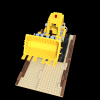

Fitting NeRF model to 85x images and postures:   0%|          | 0/1000 [00:00<?, ?it/s]

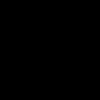

0.0012541281757876277

Fitting NeRF model to 85x images and postures:   3%|          | 28/1000 [00:38<21:30,  1.33s/it]

In [14]:
model = NeRF.fit(
    dataset=train_dataset,
    device="cpu",
    epochs=1000,
    rays_per_batch=2000,
    points_per_ray=40,
    seed=5336,
)